In [1]:
%matplotlib inline
import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')
from IPython.display import display, Math

import csv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import interpolate

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cmr10'
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

In [2]:
R = 1.5
H = 6

# Direct numerical integration

In [3]:
dt = 3.6
dx = 2.2e-2

t0 = 0
tf = 11341 #2*3600
xf = H

t = np.arange(t0, tf + dt, dt)
x = np.arange(0, xf + dx, dx)

dx = x[1] - x[0]
# dt = t[1] - t[0]

Nx = len(x) - 1
Nt = len(t) - 1

In [4]:
Tmin = 290 + 273
Tmax = 396 + 273
eps = 0.22

In [5]:
Tavg = 0.5*(Tmax + Tmin) - 273

rhof = 2090 - 0.636*Tavg
muf = 0.0021 #(22.174 - 0.12*Tavg + 2.281e-4*Tavg**2 - 1.474e-7*Tavg**3)/1000
cpf = 1443 + 0.172*Tavg
kf = 0.443 + 0.00019*Tavg

d = 0.015
mDot = 7.0

# velocidad
u = mDot/(eps*rhof*np.pi*R**2)
u0 = eps*u

rhos = 2500
cps = 830
ks = 5.69

In [6]:
CFL = dt*u/dx
print('CFL = ', CFL)
print('u = ', u)

CFL =  0.3935059292030513
u =  0.0024047584562408688


In [7]:
Tin = Tmin

T0 = 800

Tf = np.zeros((Nt+1, Nx+1))
Ts = np.zeros((Nt+1, Nx+1))

# BCs
Tf[:,0] = Tin

# ICs
Tf[0,:] = T0
Ts[0,:] = T0

In [8]:
rChar = eps*d/(4*(1-eps))
G = mDot/(eps*np.pi*R**2)
Re = 4*G*rChar/muf
Pr = cpf*muf/kf

Sr = 2*3*np.pi*R**2*(1 - eps)/d

h = 0.191*mDot*cpf/(eps*np.pi*R**2)*Re**(-0.278)*Pr**(-2/3)

In [9]:
# Transport-term coeffs.
alpha = eps*rhof*cpf
gamma = (1 - eps)*rhos*cps

# Diffusive-term coeffs.
beta = eps*kf
betas = (1 - eps)*ks

# Calculation of heat transfer coeff.
Rep = rhof*d*u/muf
Pr = cpf*muf/kf
Nu = 0.664*Rep**0.5*Pr**0.5
a = Nu*kf/d
#h = 6*(1-eps)*beta*(2 + 1.1*Rep**(0.6)*Pr**(1/3))/(d**2)

# Heat transfer coeff.
h = a*6*(1-eps)/d

In [10]:
# Matrix terms
p = u*dt/dx

q = beta/alpha*dt/(dx**2)
qs = betas*dt/(gamma*dx**2)

r = h*dt/alpha
rs = h*dt/gamma

In [11]:
# Implicit form of heat transfer term
diagonals = [np.ones(Nx)*(1 + 2*q + r + p), np.ones(Nx)*(-q), np.ones(Nx)*(-p-q)]

# Explicit form of heat transfer term
# diagonals = [np.ones(Nx)*(1 + 2*q + p), np.ones(Nx)*(-q), np.ones(Nx)*(-p-q)]

offsets = [0, 1, -1]
A = sp.sparse.diags(diagonals, offsets).toarray()
A[-1,-2] = -2*q - p

A = sp.sparse.csr_matrix(A)

In [12]:
# Implicit form of heat transfer term
diagonals = [np.ones(Nx + 1)*(1 + 2*qs + rs), np.ones(Nx + 1)*(-qs), np.ones(Nx + 1)*(-qs)]

# Explicit form of heat transfer term
# diagonals = [np.ones(Nx + 1)*(1 + 2*qs), np.ones(Nx + 1)*(-qs), np.ones(Nx + 1)*(-qs)]

offsets = [0, 1, -1]
As = sp.sparse.diags(diagonals, offsets).toarray()
As[-1,-2] = -2*qs
As[0,1] = -2*qs

As = sp.sparse.csr_matrix(As)

In [13]:
bc0 = np.zeros(Nx)
bc1 = np.zeros(Nx)

bc0[0] = Tin
bc1[0] = Tin

In [14]:
for i in range(1,Nt+1):
    
#   Heat transfer coupling is performed semi-implicitly in every other equation 
    if(i % 2 == 0):
        Ts[i,:] = sp.sparse.linalg.spsolve(As, Ts[i-1,:] + rs*Tf[i-1,:])

        Tf[i,1:] = sp.sparse.linalg.spsolve(A, Tf[i-1,1:] + (q + p)*bc1 + \
                    r*Ts[i,1:])
    else:
        Tf[i,1:] = sp.sparse.linalg.spsolve(A, Tf[i-1,1:] + (q + p)*bc1 + \
                    r*Ts[i-1,1:])    
        Ts[i,:] = sp.sparse.linalg.spsolve(As, Ts[i-1,:] + rs*Tf[i,:])



#     Ts[i,:] = sp.sparse.linalg.spsolve(As, Ts[i-1,:] + rs*(Tf[i-1,:] - Ts[i-1,:]))
#     Tf[i,1:] = sp.sparse.linalg.spsolve(A, Tf[i-1,1:] + (q + p)*bc1 - r*(Tf[i-1,1:] - Ts[i-1,1:]))


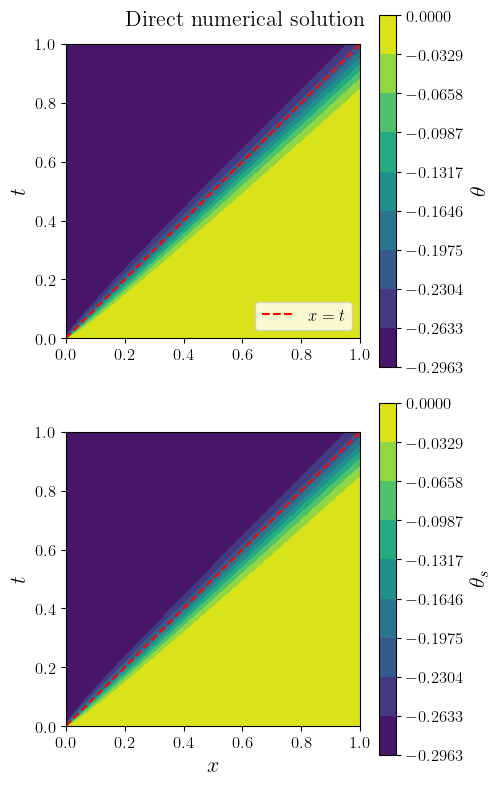

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,8), sharex='row')
(ax1, ax2) = axs

thetaf = (Tf - T0)/T0
thetas = (Ts - T0)/T0


cs1 = ax1.contourf(x/H, t*u0/H, thetaf, np.linspace(thetaf.min(), thetaf.max(), 10))
ax1.plot(x/H, x/H,'r--', label=r'$x = t$')
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$\theta$', fontsize=16)
ax1.set_ylabel(r'$t$',fontsize=16)
ax1.set_box_aspect(1)
ax1.legend(loc='lower right')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

cs2 = ax2.contourf(x/H, t*u0/H, thetas, np.linspace(thetaf.min(), thetaf.max(), 10))
ax2.plot(x/H, x/H,'r--')
plt.tight_layout()
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$\theta_s$', fontsize=16)
ax2.set_xlabel(r'$x$',fontsize=16)
ax2.set_ylabel(r'$t$',fontsize=16)
ax2.set_box_aspect(1)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

fig.suptitle('Direct numerical solution')

fig.savefig('T_vs_x_t.pdf', dpi=300)
plt.show()

In [16]:
nt0h = int(0)
nt0p5h = int(H/u0/dt/8)
nt1h = int(2*H/u0/dt/8)
nt1p5h = int(3*H/u0/dt/8)
nt2h = int(4*H/u0/dt/8)

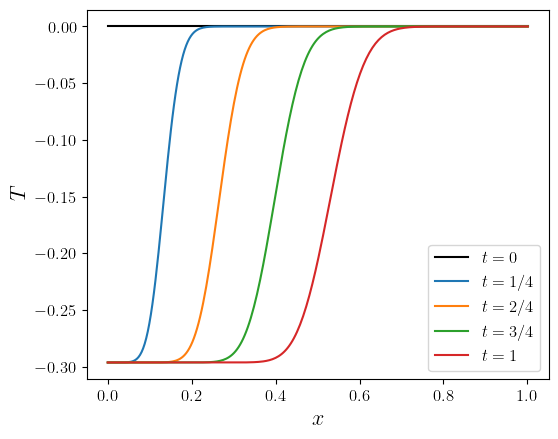

In [17]:
fig, ax = plt.subplots()
plt.plot(x/H, thetaf[nt0h,:], 'k', x/H, thetaf[nt0p5h,:], x/H, \
         thetaf[nt1h,:], x/H, thetaf[nt1p5h,:], x/H, thetaf[nt2h,:])

plt.gca().set_prop_cycle(None)
plt.legend([r'$t = 0$', r'$t = 1/4$', r'$t = 2/4$', r'$t = 3/4$', r'$t = 1$'])
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)
fig.savefig('profiles.pdf', dpi=300,
            orientation='portrait')
plt.show()

# Method of Characteristics

In [37]:
Lambda = h*H/(rhof*cpf*u0/eps)
Lambdas = h*H/(rhos*cps*u0/(1-eps))

In [52]:
# Grid
dt = 1/Lambdas
dx = dt
xc = np.arange(0, 1+dx, dx)
tc = np.arange(0, 1+dt, dt)

In [53]:
display(Math(r'\Delta t \, \Lambda_s = ' + str(dt*Lambdas)))
display(Math(r'\Delta t \, \Lambda = ' + str(np.round(dt*Lambda, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [54]:
# Discretization
xvc, tvc = np.meshgrid(xc, tc, indexing='ij')

Cp = xvc*0
Cn = xvc*0

Tsc = xvc*0
Tfc = xvc*0


# BCs
Tfc[0,:] = (Tin - T0)/T0

# ICs
Tfc[:,0] = 0
Tsc[:,0] = 0

# Characteristics initialization
Cp[:,0] = tc[0] + xc
Cn[:,0] = xc

In [55]:
# Numerical integration of the characteristic equations
for j in range(1,len(tc)): 
    Cp[:,j] = tc[j] + xc
    Cn[:,j] = xc

    for i in range(1,len(xc)):
    #   Heat transfer coupling is performed semi-implicitly in every other equation 
        if(i % 2 == 0):
            Tsc[i-1,j] = Lambdas*dt*(Tfc[i-1,j-1] - Tsc[i-1,j-1]) + Tsc[i-1,j-1]
            Tfc[i,j] = -Lambda*dt*(Tfc[i-1,j-1] - Tsc[i-1,j]) + Tfc[i-1,j-1]
        else:
            Tfc[i,j] = -Lambda*dt*(Tfc[i-1,j-1] - Tsc[i-1,j-1]) + Tfc[i-1,j-1]
            Tsc[i-1,j] = Lambdas*dt*(Tfc[i-1,j] - Tsc[i-1,j-1]) + Tsc[i-1,j-1]


Plot characteristics. Solid blue lines $C^+$, and dashed red $C^-$.

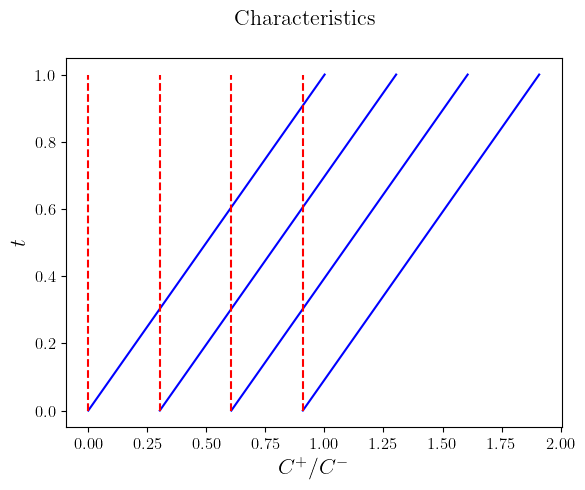

In [56]:
fig, axs = plt.subplots()

axs.plot(Cp[::128,:].T, tc, 'b-')
axs.plot(Cn[::128,:].T, tc, 'r--')

axs.set_ylabel(r'$t$', fontsize=16)
axs.set_xlabel(r'$C^+/C^-$', fontsize=16)

fig.suptitle('Characteristics')

fig.savefig('characteristics.pdf', dpi=300,
            orientation='portrait')

plt.show()

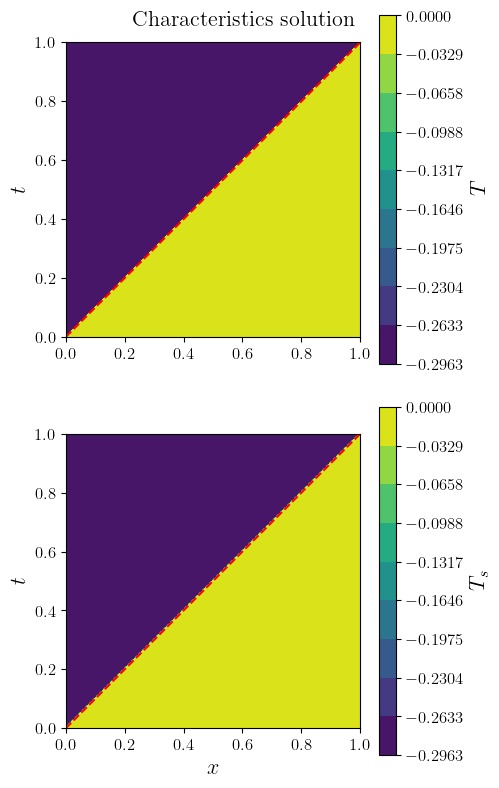

In [57]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,8), sharex='row')
(ax1, ax2) = axs

cs1 = ax1.contourf(xvc, tvc, Tfc, np.linspace(Tfc.min(), Tfc.max(), 10))
ax1.plot(tc, tc, 'r--')
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T$', fontsize=16)
ax1.set_ylabel(r'$t$', fontsize=16)
ax1.set_box_aspect(1)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

cs2 = ax2.contourf(xvc, tvc, Tsc, np.linspace(Tsc.min(), Tsc.max(), 10))
ax2.plot(tc, tc, 'r--')
plt.tight_layout()
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$T_s$', fontsize=16)
ax2.set_xlabel(r'$x$', fontsize=16)
ax2.set_ylabel(r'$t$', fontsize=16)
ax2.set_box_aspect(1)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

fig.suptitle('Characteristics solution')

fig.savefig('T_vs_x_t_characteristics_dtLambdas_1.pdf', dpi=300)
plt.show()

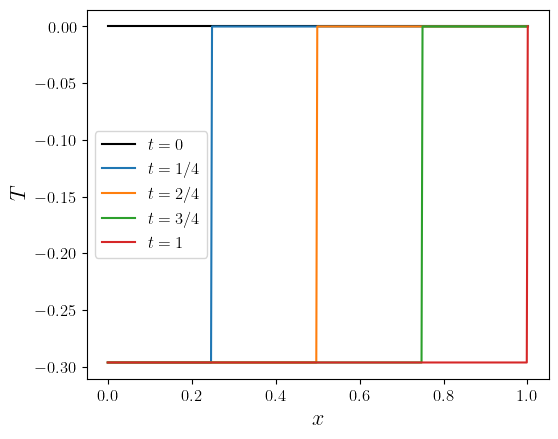

In [58]:
fig, ax = plt.subplots()
plt.plot(xc, Tfc[:,0], 'k', xc, Tfc[:,int(len(tc)/4)-1], xc, Tfc[:,int(2*len(tc)/4)-1],
         xc, Tfc[:,int(3*len(tc)/4)-1], xc, Tfc[:,-1])

plt.legend([r'$t = 0$', r'$t = 1/4$', r'$t = 2/4$', r'$t = 3/4$', r'$t = 1$'])
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)

fig.savefig('profiles_characteristics_dtLambdas_1.pdf', dpi=300,
            orientation='portrait')
plt.show()